# Building a Part of Speech Tagger with Keras

This notebook is based on nlpforhackers' post: https://nlpforhackers.io/lstm-pos-tagger-keras/. We will look at how to build a part of speech tagger using a LSTM layer.

We will use NLTK's treebank corpus. This corpus has, among other kinds of information, annotations about the parts of speech of the words.

In [1]:
import nltk
nltk.download('treebank')

tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


As always, before training a model, we need to split the data in training and testing data:

In [0]:
import random
random.seed(1234)
tagged_sentences = list(tagged_sentences) # we convert the data to a list
random.shuffle(tagged_sentences)

In [0]:
threshold = int(len(tagged_sentences)*.6)
train = tagged_sentences[:threshold]
test = tagged_sentences[threshold:]

Let’s restructure the data a bit. Let’s separate the words from the tags.

In [0]:
import numpy as np
 
train_sentences, train_tags =[], [] 
for tagged_sentence in train:
    sentence, tags = zip(*tagged_sentence)
    train_sentences.append(np.array(sentence))
    train_tags.append(np.array(tags))
    
test_sentences, test_tags =[], [] 
for tagged_sentence in test:
    sentence, tags = zip(*tagged_sentence)
    test_sentences.append(np.array(sentence))
    test_tags.append(np.array(tags))

In [5]:
print(train_sentences[5])
print(train_tags[5])

['They' 'are' 'keeping' 'a' 'close' 'watch' 'on' 'the' 'yield' 'on' 'the'
 'S&P' '500' '.']
['PRP' 'VBP' 'VBG' 'DT' 'JJ' 'NN' 'IN' 'DT' 'NN' 'IN' 'DT' 'NNP' 'CD' '.']


Let's now convert the words and tags to indices. We will reserve index 0 for padding, and index 1 for words that are out of the vocabulary (**OOV - Out of Vocabulary**).

In [0]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())
 
for ts in train_tags:
    for t in ts:
        tags.add(t)
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # There may also be unknown tags in the test data

In [7]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []
 
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
 
for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)
 
for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])
 
for s in test_tags:
    s_int = []
    for t in s:
        try:
            s_int.append(tag2index[t])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    test_tags_y.append(s_int)
 
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[608, 1472, 7273, 6180, 8361, 4026, 7926, 2929]
[1447, 6569, 844, 8084, 5333, 1, 2200, 6384, 2627, 6771, 3773, 6384, 1, 181, 6908, 8361, 6508, 7064, 6384, 1760, 3003, 1, 2929]
[27, 25, 30, 23, 36, 22, 22, 41]
[38, 23, 17, 20, 23, 17, 32, 16, 3, 38, 17, 16, 17, 32, 17, 36, 42, 17, 16, 32, 37, 17, 41]


Since Keras can only deal with fixed size sequences, we will pad all sequences to fit the longest sentence in the training data.

In [8]:
MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)

271


In [9]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

Using TensorFlow backend.


[ 608 1472 7273 6180 8361 4026 7926 2929    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

We can now define the model. 
A simple approach to build a part-of-speech tagger in Keras is to stack a dense layer at the output of each RNN cell. This is achieved with `TimeDistributed`. Note  how the output of the model is now a list of sequences of vectors. Each vector will contain the probability of each tag. In particular:

* We will introduce an embedding layer.
* THe LSTM layer will have the parameter `return_sequences=True` so that we have access to the entire sequence.
* The output of each LSTM cell will have a `Dense` layer. We can do this using the `TimeDistributed` layer.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
 
 
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 271, 128)          1111424   
_________________________________________________________________
lstm_1 (LSTM)                (None, 271, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 271, 47)           12079     
_________________________________________________________________
activation_1 (Activation)    (None, 271, 47)           0         
Total params: 1,517,743
Trainable params: 1,517,743
Non-trainable params: 0
_________________________________________________________________


We also need to convert the labels into one-hot encoding. Since the input are sequences of labels we cannot use Keras' `to_categorical` so we define our own function:

In [0]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [12]:
cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))
print(cat_train_tags_y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


We can finally train the model:

In [13]:
history = model.fit(train_sentences_X, cat_train_tags_y, batch_size=128, epochs=40, validation_split=0.2)
 

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1878 samples, validate on 470 samples
Epoch 1/40
1878/1878 [==============================] - 12s 7ms/step - loss: 1.7536 - acc: 0.8438 - val_loss: 0.6165 - val_acc: 0.9036
Epoch 2/40
1878/1878 [==============================] - 9s 5ms/step - loss: 0.7007 - acc: 0.8763 - val_loss: 0.4678 - val_acc: 0.9037
Epoch 3/40
1878/1878 [==============================] - 9s 5ms/step - loss: 0.4189 - acc: 0.9056 - val_loss: 0.4092 - val_acc: 0.9043
Epoch 4/40
1878/1878 [==============================] - 9s 5ms/step - loss: 0.3900 - acc: 0.9061 - val_loss: 0.3853 - val_acc: 0.9040
Epoch 5/40
1878/1878 [==============================] - 9s 5ms/step - loss: 0.3726 - acc: 0.9062 - val_loss: 0.3740 - val_acc: 0.9041
Epoch 6/40
1878/1878 [==============================] - 9s 5ms/step - loss: 0.3576 - acc: 0.9062 - val_loss: 0.3672 - val_acc: 0.9041
Epoch 7/40
1878/1878 [

If the results look too good, it's because they are too good! We need to ignore the classification of the padded symbols, but let's leave it aside for now. Below is an evaluation using the test data.

In [14]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

1566/1566 [==============================] - 11s 7ms/step
acc: 96.76379513466496


Let's find the PoS of two test sentences:

In [15]:
test_samples = [
    "running is very important for me .".split(),
    "I was running every day for a month .".split()
]
print(test_samples)

[['running', 'is', 'very', 'important', 'for', 'me', '.'], ['I', 'was', 'running', 'every', 'day', 'for', 'a', 'month', '.']]


These test sentences need to be vectorised:

In [16]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)
 
test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[3754 5970 4765 4048 4260 3809 2929    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

And the predictions are ...

In [17]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[2.91282479e-02 1.88667346e-02 1.89538840e-02 ... 1.99475978e-02
   1.79031510e-02 1.74484272e-02]
  [4.02032435e-02 1.36810364e-02 1.61603559e-02 ... 1.65906642e-02
   1.41995354e-02 1.28826033e-02]
  [2.85787806e-02 8.16254970e-03 1.41121214e-02 ... 1.23855462e-02
   1.44241638e-02 6.86419895e-03]
  ...
  [9.99904513e-01 5.17404248e-14 1.22004394e-11 ... 1.90587433e-12
   2.80383762e-14 7.35508795e-14]
  [9.99904513e-01 5.17822852e-14 1.22030224e-11 ... 1.90607794e-12
   2.80099396e-14 7.35358700e-14]
  [9.99904633e-01 5.18243793e-14 1.22056072e-11 ... 1.90628893e-12
   2.79813743e-14 7.35205828e-14]]

 [[2.80413087e-02 1.51930703e-02 1.81705691e-02 ... 1.76218972e-02
   1.74059626e-02 1.45811960e-02]
  [3.12418342e-02 9.50537995e-03 1.50221204e-02 ... 1.29120313e-02
   1.52053805e-02 8.47656094e-03]
  [3.91318537e-02 7.02448050e-03 1.37202442e-02 ... 1.28371343e-02
   1.30154779e-02 5.18636452e-03]
  ...
  [9.99900579e-01 7.95620351e-14 1.56737418e-11 ... 2.54195926e-12
   2.53709

These predictions show, for each word, the probabilities assigned to each possible label. Let's choose the label with the highest probability (using numpy's `argmax`) and then convert from label index to label:

In [0]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [19]:
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

[['CD', '-PAD-', ',', 'DT', 'IN', 'NNS', '.', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

As expected, the padding symbol is over-used. To solve this problem we can define a custom accuracy metric that ignores the paddings. Remember that the index for the padding symbol is 0:

In [0]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

Let's now retrain using this new accuracy metric:

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
 
 
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 271, 128)          1111424   
_________________________________________________________________
lstm_2 (LSTM)                (None, 271, 256)          394240    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 271, 47)           12079     
_________________________________________________________________
activation_2 (Activation)    (None, 271, 47)           0         
Total params: 1,517,743
Trainable params: 1,517,743
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras.callbacks import EarlyStopping
history = model.fit(train_sentences_X, cat_train_tags_y, batch_size=128, epochs=100, validation_split=0.2) #,
#                    callbacks=[EarlyStopping(monitor='val_ignore_accuracy')])

Train on 1878 samples, validate on 470 samples
Epoch 1/100
1878/1878 [==============================] - 10s 5ms/step - loss: 1.7742 - acc: 0.8438 - ignore_accuracy: 0.0110 - val_loss: 0.6140 - val_acc: 0.9036 - val_ignore_accuracy: 0.0000e+00
Epoch 2/100
1878/1878 [==============================] - 9s 5ms/step - loss: 0.6275 - acc: 0.8870 - ignore_accuracy: 0.0494 - val_loss: 0.4716 - val_acc: 0.9036 - val_ignore_accuracy: 0.0663
Epoch 3/100
1878/1878 [==============================] - 9s 5ms/step - loss: 0.4263 - acc: 0.9055 - ignore_accuracy: 0.1279 - val_loss: 0.4114 - val_acc: 0.9040 - val_ignore_accuracy: 0.1249
Epoch 4/100
1878/1878 [==============================] - 9s 5ms/step - loss: 0.3923 - acc: 0.9059 - ignore_accuracy: 0.1154 - val_loss: 0.3885 - val_acc: 0.9039 - val_ignore_accuracy: 0.1071
Epoch 5/100
1878/1878 [==============================] - 9s 5ms/step - loss: 0.3714 - acc: 0.9061 - ignore_accuracy: 0.1194 - val_loss: 0.3821 - val_acc: 0.9039 - val_ignore_accuracy: 

In [23]:
predictions = model.predict(test_samples_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

[['VBG', 'VBZ', 'RB', 'JJ', 'IN', 'PRP', '.', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

We can see the great difference in accuracy when we ignore the padding symbol. Also, note that the results reported by the original post https://nlpforhackers.io/lstm-pos-tagger-keras/ are better, probably because they used two LSTM chains: one going forwards, and another going backwards. This is what is called a **bidirectional recurrent network**, and it usually reports better results because each prediction is based on the context on the left and the right of the token.

In [24]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_ignore_accuracy', 'loss', 'acc', 'ignore_accuracy'])

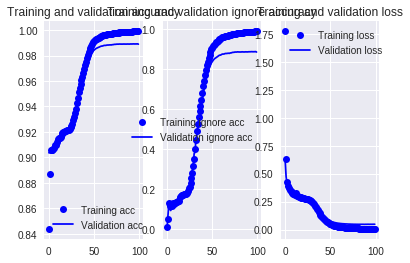

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
ignore_acc = history.history['ignore_accuracy']
val_ignore_acc = history.history['val_ignore_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(131)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(132)
plt.plot(epochs, ignore_acc, 'bo', label='Training ignore acc')
plt.plot(epochs, val_ignore_acc, 'b', label='Validation ignore acc')
plt.title('Training and validation ignore accuracy')
plt.legend()

plt.subplot(133)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
